# Tutorial: Concept Activation Maps
## Adapting pixel attribution methods for embedding outputs from models
![concept_activation_map.png](https://raw.githubusercontent.com/jacobgil/pytorch-grad-cam/master/examples/embeddings.png)


In some cases deep learning models output a feature vector, also called sometimes an "embedding".
This embedding can then be compared to other embeddings to compute how similar they are.


A few examples of where this happens:
- In face recognition, where the model is trained to give similar feature representations to face images of the same person, and different representations to face images of different people.

- In image retreival, where we want to retreive images that have similar embeddings.

- In self supervised networks - often trained by creating different augmented views of the same image, and teaching the model to give close representations to these views.



In this tutorial we will adapt pixel attribution methods for embedding networks (as apposed for just vanilla classification networks).

We will have a reference embedding - our "concept".

That question we want to answer is: 

**"What in the image is similar, or different, than the concept embedding ?"**


To achieve this We will create a target function that computes the similarity from the model output with a reference embedding.

First, lets create our own network that outputs feature vectors. 
We're going to just use the output from the resnet50 Global Average Pooling layer, and remove the fully connected part.

In [15]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
from torchvision.models.segmentation import deeplabv3_resnet50
import torch
import torch.functional as F
import numpy as np
import requests
import cv2
import torchvision
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

# A model wrapper that gets a resnet model and returns the features before the fully connected layer.
class ResnetFeatureExtractor(torch.nn.Module):
    def __init__(self, model):
        super(ResnetFeatureExtractor, self).__init__()
        self.model = model
        self.feature_extractor = torch.nn.Sequential(*list(self.model.children())[:-1])
                
    def __call__(self, x):
        return self.feature_extractor(x)[:, :, 0, 0]
        
resnet = torchvision.models.resnet50(pretrained=True)
resnet.eval()
model = ResnetFeatureExtractor(resnet)


def get_image_from_url(url):
    """A function that gets a URL of an image, 
    and returns a numpy image and a preprocessed
    torch tensor ready to pass to the model """

    img = np.array(Image.open(requests.get(url, stream=True).raw))
    img = cv2.resize(img, (512, 512))
    rgb_img_float = np.float32(img) / 255
    input_tensor = preprocess_image(rgb_img_float,
                                   mean=[0.485, 0.456, 0.406],
                                   std=[0.229, 0.224, 0.225])
    return img, rgb_img_float, input_tensor

In [16]:
car_img, car_img_float, car_tensor = get_image_from_url("https://www.wallpapersin4k.org/wp-content/uploads/2017/04/Foreign-Cars-Wallpapers-4.jpg")
cloud_img, cloud_img_float, cloud_tensor = get_image_from_url("https://th.bing.com/th/id/OIP.CmONj_pGCXg9Hq9-OxTD9gHaEo?pid=ImgDet&rs=1")
car_concept_features = model(car_tensor)[0, :]
cloud_concept_features = model(cloud_tensor)[0, :]

Lets visualize the concepts we're going to be looking for in the image.
Notice that the model is pretrained on imagenet. 
However these images don't correspond to any of the image-net categories - there are no "sky" or "car" categories in imagenet.
We're still going to be able to find these "concepts" in our query image later.

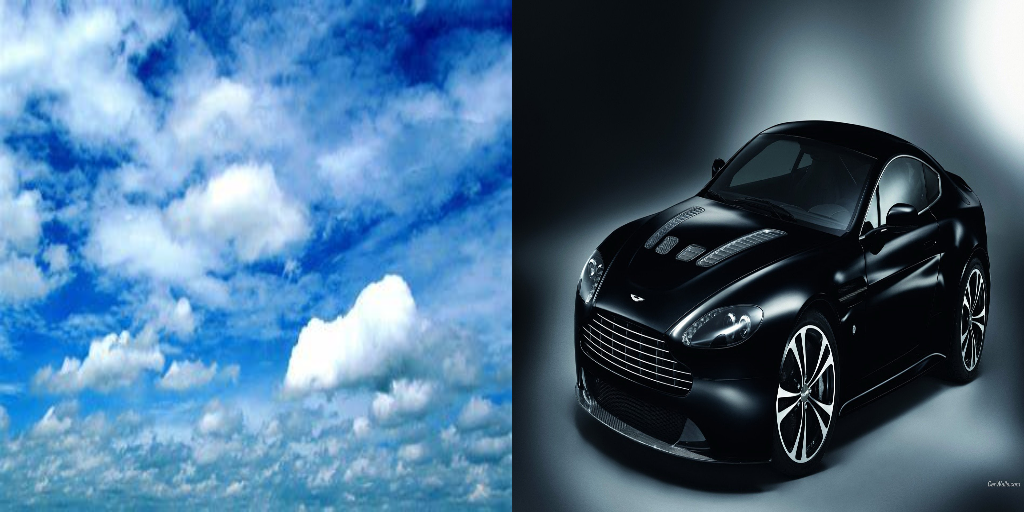

In [17]:
Image.fromarray(np.hstack((cloud_img, car_img)))

Now lets look at our query image, this is going to be the image that we're going to analyze and serch for the concepts inside it.

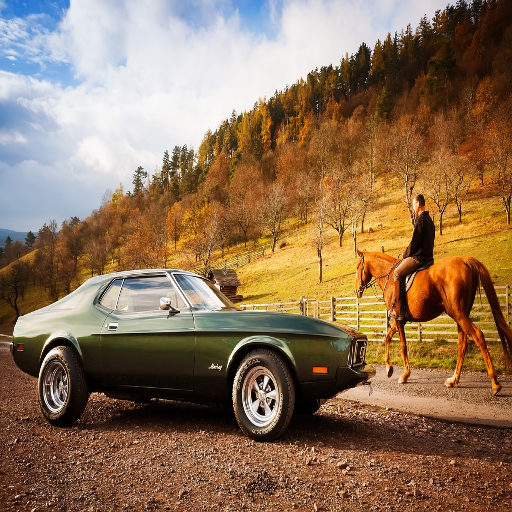

In [18]:
image, image_float, input_tensor = get_image_from_url("https://th.bing.com/th/id/R.c65135374de94dea2e2bf8fe0a4818e7?rik=Z75HF5uFr56PAw&pid=ImgRaw&r=0")
Image.fromarray(image)

To use the CAM objects we need to define two things:
- **The target function**.
  
  For classification networks this is typically one of the model category outputs, 
  
  e.g, `ClassifierOutputTarget(281)`.
  
  
 
    However here we the target to be the similarity (or dissimilarity) to a target embedding, 
  
    so we will implement it for this use case.
      
- **The target layer:** 
    Which layer with 2D spatial outputs in the model we want to use.
    
    This is typically the output of the last convolutional layer in the network.
    
 
Lets define the target function and the target layer, and create the visualizations:

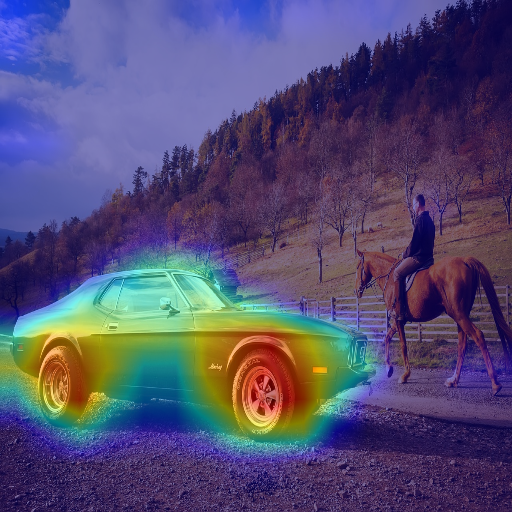

In [19]:
class SimilarityToConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)
    
target_layers = [resnet.layer4[-1]]
car_targets = [SimilarityToConceptTarget(car_concept_features)]
cloud_targets = [SimilarityToConceptTarget(cloud_concept_features)]

# Where is the car in the image
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=car_targets)[0, :]
car_cam_image = show_cam_on_image(image_float, car_grayscale_cam, use_rgb=True)
Image.fromarray(car_cam_image)

As you can see, it highlights the car in the image.
Now lets do the same, but for the cloud concept:

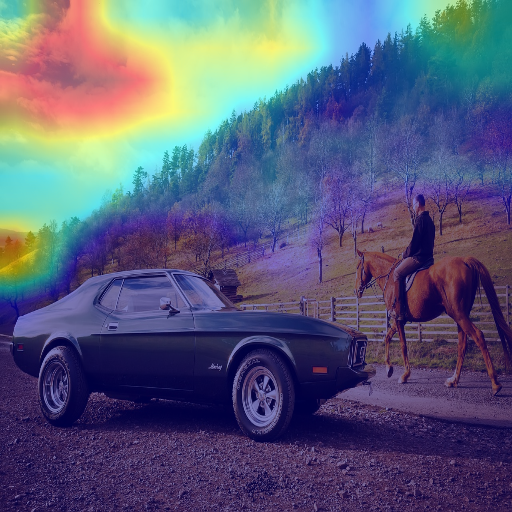

In [21]:
# Where is the cloud in the image
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=cloud_targets)[0, :]
cloud_cam_image = show_cam_on_image(image_float, cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cloud_cam_image)

Similarly we can do the same to see where the concept is NOT in the image:

In [22]:
class DifferenceFromConceptTarget:
    def __init__(self, features):
        self.features = features
    
    def __call__(self, model_output):
        cos = torch.nn.CosineSimilarity(dim=0)
        return 1 - cos(model_output, self.features)

not_car_targets = [DifferenceFromConceptTarget(car_concept_features)]
not_cloud_targets = [DifferenceFromConceptTarget(cloud_concept_features)]

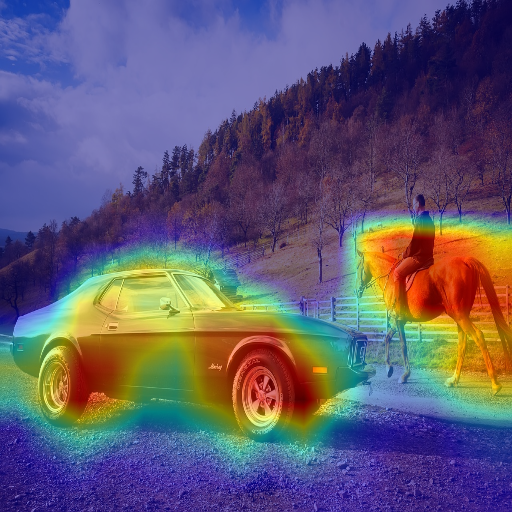

In [24]:
# Where is the cloud not in the image?
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_cloud_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_cloud_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_cloud_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

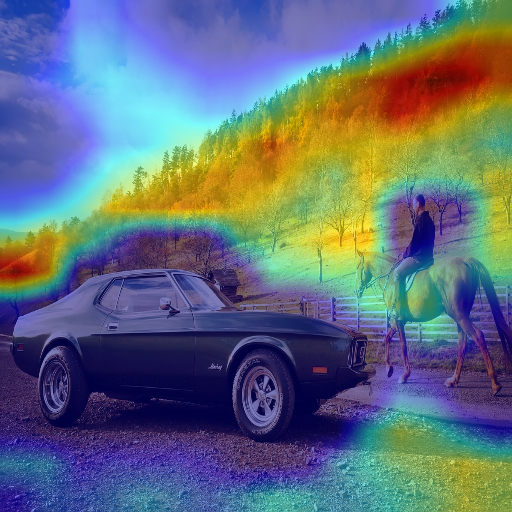

In [25]:
# Where is the car not in the image?
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    not_car_grayscale_cam = cam(input_tensor=input_tensor,
                        targets=not_car_targets)[0, :]
cam_image = show_cam_on_image(image_float, not_car_grayscale_cam, use_rgb=True)
Image.fromarray(cam_image)

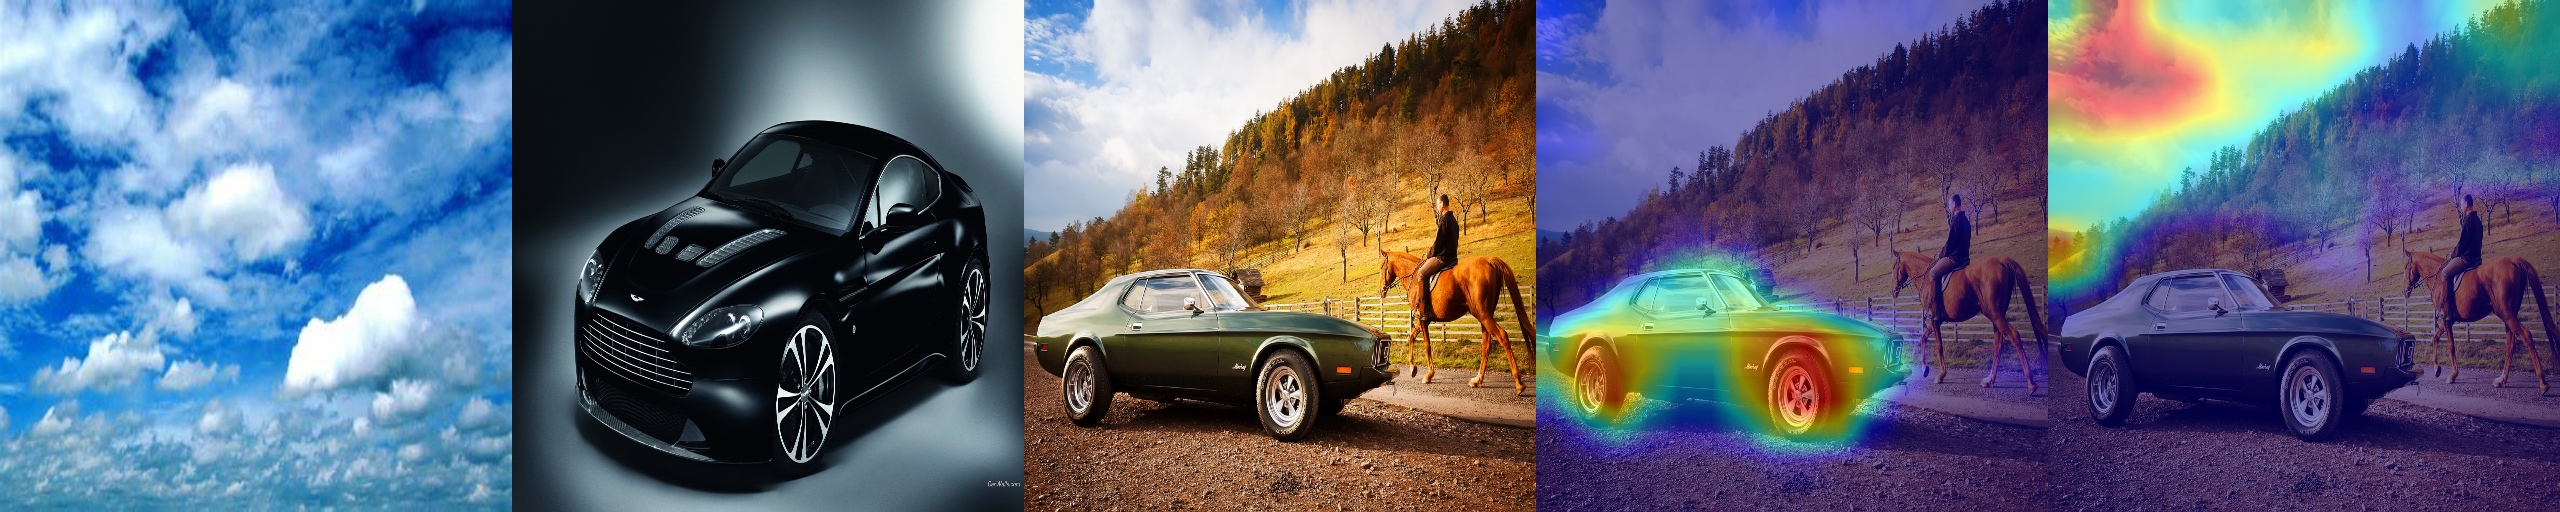

In [26]:
Image.fromarray(np.hstack((cloud_img, car_img, image, car_cam_image, cloud_cam_image)))